In [268]:
import json
import os
import cv2
import numpy as np
import pandas as pd

def get_json_data(file_path):
    with open(file_path) as data:
        json_data = json.load(data)
    return json_data



def get_images_info_from_COCO_data(COCO_data):
    return COCO_data['images']


def get_image_name_and_id_from_json(coco_images_info):
    dict_keys   = coco_images_info[0].keys()
    df          = pd.DataFrame(coco_images_info)
    del_columns = [column for column in dict_keys if column not in ['file_name', 'id']]
    df.drop(del_columns, axis = 1, inplace = True)
    df.columns  = ['image_name', 'image_id']
    return df



def get_categories_df(coco_categories_info):
    coco_categories_df = pd.DataFrame(coco_categories_info)
    coco_categories_df = coco_categories_df.set_index('id')
    return coco_categories_df



def get_annotations_df(coco_annotations_info, images_df):
    annotations_df = pd.DataFrame(coco_annotations_info)
#     images_annotations_df = pd.merge(coco_annotations_ddf, images_df, on = 'image_id')
#     images_annotations_df.drop(['bbox', 'area'], axis = 1, inplace = True)
    return annotations_df

In [4]:
COCO_data         = get_json_data('/Users/vijay/Downloads/annotations/instances_train2014.json')
coco_images_info  = get_images_info_from_COCO_data(COCO_data)
images_name_id_df = get_image_name_and_id_from_json(coco_images_info)
categories_df     = get_categories_df(COCO_data['categories'])




In [216]:


def read_coco_images(dir_path):
    images_arr   = {}
    images_names = os.listdir(dir_path)
    images_arr   = read_image_(dir_path, images_names, images_arr)
        
    return pd.DataFrame(images_arr.items(), columns = ['image_name', 'pixel_data'])

    
    
##########################################################    

def read_image_(path, image_names, images_arr):
    
    try:
        ii = 0
        for image_name in image_names:
            if image_name.split(".")[-1].lower() in {"jpeg", "jpg", "png"}:

                image     = cv2.cvtColor(cv2.imread(path + "/" + image_name), cv2.COLOR_RGB2GRAY)
                image     = image / 255  
                images_arr[str(image_name)] = image            
        return images_arr
    
    except Exception as e:
        print(str(e))
        
        
def merge_images_id_and_data_dfs(images_df, images_name_id_df):
    images_names_df = pd.merge(images_df, images_name_id_df, on = 'image_name')
    return images_names_df

In [269]:
images_df = read_coco_images('/Users/vijay/Downloads/Datasets/COCO_sample/')
images_names_df = merge_images_id_and_data_dfs(images_df, images_name_id_df)
annotations_df = get_annotations_df(COCO_data['annotations'], images_names_df)

In [378]:
import math
from matplotlib.path import Path
import matplotlib.patches as patches
import pylab


########################################################## 

def get_image_id_from_name(image_name, images_names_df):
    return_id = 0
    for _, row in images_names_df.iterrows():
        if row['image_name'] == image_name:
            return_id = row['image_id']
            break
    return return_id



########################################################## 

def get_indices_having_same_image_id(image_id, annotations_df):
    indices_list = np.where(annotations_df['image_id'] == image_id)[0]
    return indices_list



########################################################## 

def get_image_from_image_name(image_name, images_df):
    image = images_df.loc[images_df['image_name'] == image_name]['pixel_data']
    return image.iloc[0]



########################################################## 

def get_super_categories_as_one_hot_labels(categories_df):
    '''converting super categories into one-hot labels'''
    super_categories = list(set(categories_df['supercategory']))
    category_index = 1
    supercategory_dict = {}
    for category in super_categories:
        supercategory_dict[category] = category_index
        category_index = category_index + 1
    
    return supercategory_dict



########################################################## 

def get_super_category(category_id, categories_df, supercategory_dict):
    super_category = categories_df.loc[category_id]['supercategory']
    return supercategory_dict[super_category]



########################################################## 

def get_all_segmentations_for_each_image_id(image_id, annotations_df, categories_df, supercategory_dict):
    segmentation_list     = []
    indices_with_image_id = get_indices_having_same_image_id(image_id, annotations_df)
    for index in indices:
        row              = annotations_df.loc[index]
        spr_category_val = get_super_category(row['category_id'], categories_df, supercategory_dict)
        segmentation_list.append((row['segmentation'], spr_category_val))
    
    return segmentation_list
    


########################################################## 

def convert_segmentation_vals_as_xy(segmentation_li):
    try:
        len_seg   = np.shape(segmentation_li)[0]
        xy = [(segmentation[index], segmentation[index + 1]) for index in range(0, len_seg, 2)]
        return xy
    except Exception as e:
        print('error in convert_segmentation_vals_as_xy')

        

        

def form_a_closed_region_with_points(xy):
    pass
    
#     p = Path(xy) # make a polygon
#     grid = p.contains_points(xy)
    

    
########################################################## 


def check_if_the_points_are_inside_polygon(polygon, image, category_id):
    pass
    '''
    for each_point in image:
        if each_point is in polygon:
            image[index_of_each_point] = category_id
    
    return image
    '''
    
    
def fill_non_category_values_with_0(image, num_of_categories):
    shape_of_im = np.shape(image)
    flat_image = image.reshape(1, -1)
    flat_image[np.where(flat_image not in range(1, num_of_categories))] = 0
    return flat_image.reshape(shape_of_im)
    
########################################################## 

def label_the_images_with_super_categories(image, segmentation_list):
    

    '''Segmentation in annotations is a list of lists
    --- in the function get_all_segmentations_for_each_image_id, we collected all the segmentation
    related to one image_id and then grouped them into another list.
    --- Thereore, segmentation_list in this method is a list of list of lists'''
    for segmenation in segementation_list:
        xy = []
        for sub_segementation in segmentation:
            xy = xy + convert_segmentation_vals_as_xy(sub_segmentation[0])
            
        polygon = form_a_closed_region_with_points(xy)
        im_zeros = np.zeros(np.shape(image))
        im_zeros = check_if_the_points_are_inside_polygon(polygon, im_zeros, sub_segmention[1])
    
            
            
            
            
########################################################### 
def start_labelling_the_images(images_df, images_names_df, annotations_df, categories_df):
    images_names       = np.array(images_df['image_name'])
    supercategory_dict = get_super_categories_as_one_hot_labels(categories_df)
    for image_name in images_names:
        image_id      = get_image_id_from_name(image_name, images_names_df)
        image         = get_image_from_image_name(image_name, images_df)
        segments_list = get_all_segmentations_for_each_image_id(image_id, annotations_df, categories_df,
                                                                           supercategory_dict)
        
        
        
        
    

In [237]:
temp = image
h, w = np.shape(temp)
for seg in seg_list:
    len_seg = (np.shape(seg[0])[1])
    for val in seg[0]:
        for k in range(0, len_seg, 2):
            if val[k] <= h and val[k + 1] <= w:
                x, y = val[k], val[k + 1]
            #print(x, y)
                temp[int(x), int(y)] = seg[1]
                print([int(x), int(y)])

[367, 292]
[379, 281]
[375, 264]
[369, 264]
[367, 270]
[356, 269]
[351, 284]
[340, 296]
[330, 295]
[329, 276]
[323, 230]
[321, 207]
[321, 198]
[314, 173]
[321, 162]
[324, 143]
[344, 139]
[363, 141]
[376, 148]
[386, 162]
[388, 174]
[388, 180]
[383, 185]
[386, 194]
[389, 209]
[390, 230]
[396, 251]
[399, 267]
[401, 283]
[389, 292]
[377, 294]
[365, 296]
[201, 38]
[393, 30]
[518, 34]
[514, 381]
[465, 384]
[460, 369]
[463, 347]
[467, 326]
[467, 303]
[472, 289]
[456, 291]
[445, 295]
[432, 301]
[404, 296]
[392, 295]
[368, 288]
[360, 293]
[367, 310]
[364, 332]
[364, 355]
[371, 369]
[367, 376]
[330, 378]
[326, 366]
[316, 274]
[306, 243]
[309, 217]
[316, 194]
[319, 170]
[319, 157]
[312, 124]
[309, 111]
[282, 142]
[249, 152]
[232, 152]
[200, 126]
[325, 505]
[325, 479]
[364, 378]
[351, 321]
[360, 308]
[360, 299]
[360, 293]
[380, 279]
[387, 287]
[413, 287]
[441, 291]
[447, 286]
[467, 287]
[474, 311]
[471, 326]
[471, 383]
[474, 392]
[485, 444]
[485, 496]
[492, 515]
[276, 150]
[301, 117]
[309, 119]
[3

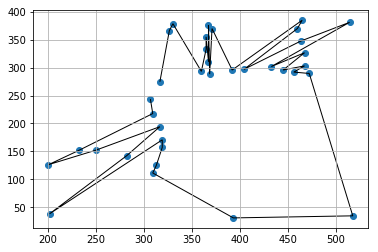

In [256]:
import math
import matplotlib.patches as patches
import pylab
# pp=[1.0), , (0.49999990000000505, 1.0), (-1.0, 0.0), (-0.0, -1.0), (0.0, 1.0), (1.0, 0.0), (-0.500000050000005, -0.5)]
# compute centroid

pp = xy
cent=(sum([p[0] for p in pp])/np.shape(pp)[0],sum([p[1] for p in pp])/np.shape(pp)[0])
# sort by polar angle
pp.sort(key=lambda p: math.atan2(p[1]-cent[1],p[0]-cent[0]))
# plot points
pylab.scatter([p[0] for p in pp],[p[1] for p in pp])
# plot polyline
pylab.gca().add_patch(patches.Polygon(pp,closed=False,fill=False))
pylab.grid()
pylab.show()

In [366]:
from matplotlib.path import Path

p = Path(xy) # make a polygon
grid = p.contains_points(xy)
print(type(grid))
# mask = grid.reshape(6, 6)

<class 'numpy.ndarray'>


In [265]:
p.contains_points([(300, 40)])

array([False])

In [375]:
# seg = annotations_df.loc[622]['segmentation']
roww = annotations_df[annotations_df['image_id'] == 1319]
seg = roww['segmentation']
print(np.shape(seg))
xy = []
for segg in seg:
    for se in segg:
        xy = xy + [(se[index], se[index + 1]) for index in range(0, np.shape(se)[0], 2)]
        print(np.shape(xy))

(8,)
(32, 2)
(68, 2)
(98, 2)
(139, 2)
(175, 2)
(187, 2)
(197, 2)
(203, 2)


In [396]:
im_name = list(images_names_df[images_names_df['image_id'] == 1319]['image_name'])
rowwim = np.array(images_df[images_df['image_name'] == im_name[0]]['pixel_data'])[0]


In [412]:
ln = np.array(li).reshape(600, 518)
lnn = np.where(ln == True)

In [421]:
def fill_non_category_values_with_0_s(image, l):
    shape_of_im = np.shape(image)
    flat_image = image.reshape(1, -1)
    indices = np.where(flat_image < 6)
    flat_image[indices] = False
    return flat_image.reshape(shape_of_im)

l = [2, 5, 8, 10]
li = np.arange(16).reshape(4, 4)
fill_non_category_values_with_0_s(li, l)

array([[ 0,  0,  0,  0],
       [ 0,  0,  6,  7],
       [ 8,  9, 10, 11],
       [12, 13, 14, 15]])